In [10]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import plotly.express as px

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [11]:
rates = pd.read_csv('data/Radioactivity in the ground at 2 hourly intervals over one year July 2.csv')
rates = rates.rename(columns={'Unnamed: 0': 'Time'})

data = rates.set_index('Time').sort_index()

In [12]:
print(data)

      dose_rate
Time           
1      0.099992
2      0.099169
3      0.103160
4      0.106554
5      0.101224
...         ...
4366   0.107107
4367   0.106559
4368   0.105592
4369   0.105697
4370   0.105409

[4370 rows x 1 columns]


In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from numpy import asarray

n_vars = 1 if type(data) is list else data.shape[1]
cols = list()
for i in range(1, 0, -1):
    cols.append(data.shift(i))
for i in range(0, 1):
    cols.append(data.shift(-i))

agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
list_for_forecast = agg.values

len(list_for_forecast)

4369

In [14]:
def decision_tree_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]

    model = DecisionTreeRegressor(random_state=0)    
    model.fit(trainX, trainy)

    yhat = model.predict([testX])
    return yhat[0]

def random_forest_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]

    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    
    yhat = model.predict([testX])
    return yhat[0]

In [18]:
predictions = list()
size = int(len(list_for_forecast) * 0.99)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = random_forest_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

error = mean_absolute_error(test[:, -1], predictions)
print("Random Forest error: ", error)

Random Forest error:  0.0033889699841323268


In [19]:
print("Random Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Random Forest metrics: 
RMSE: 0.006182866297426907
MAPE: 0.030463899314852157
MAE: 0.0033889699841323268
R2:  -0.5646280338112111


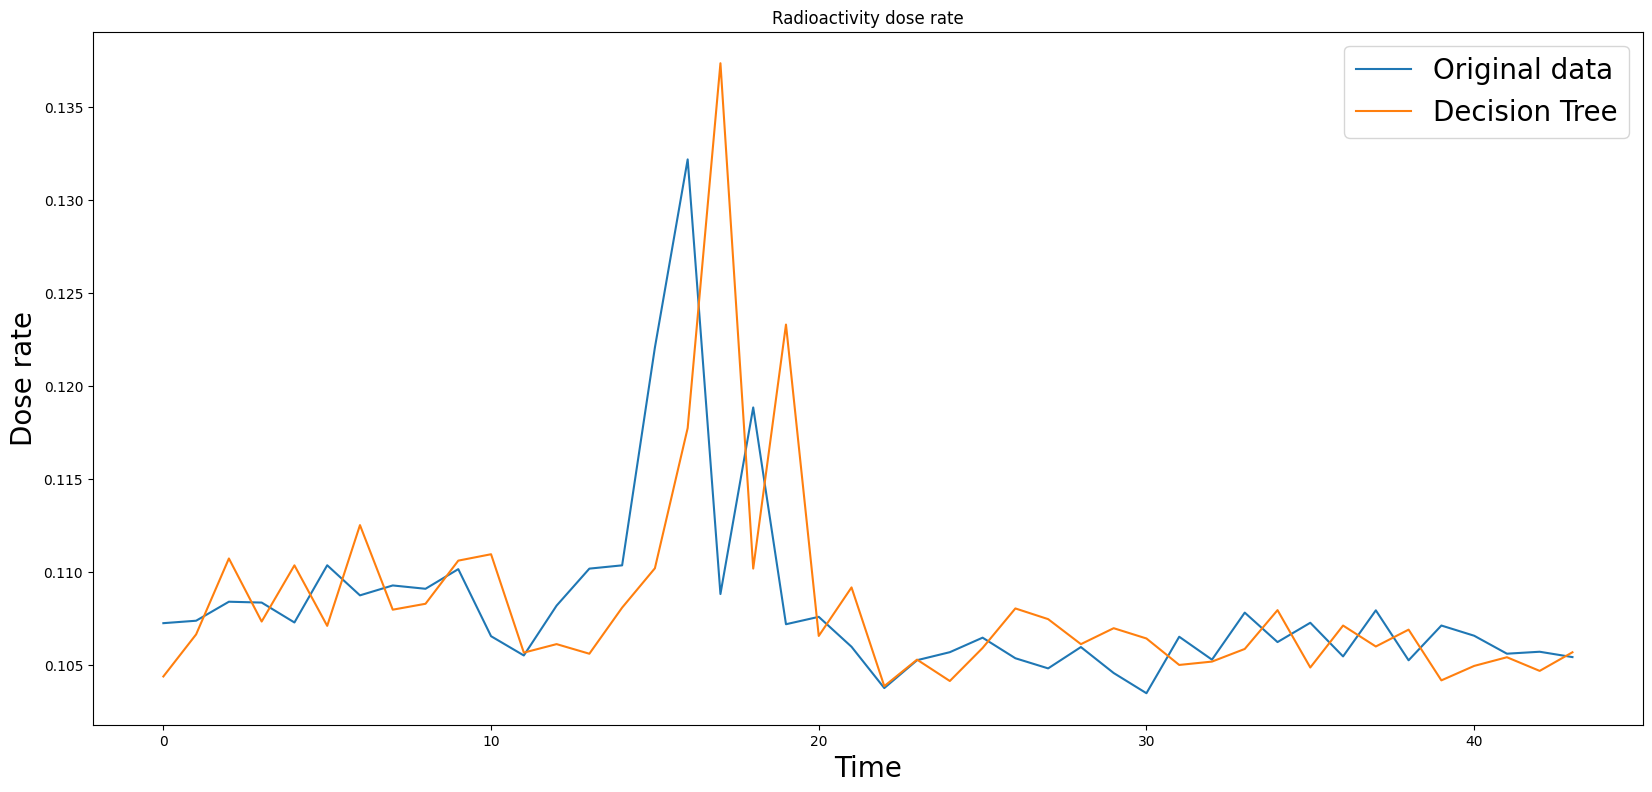

In [21]:
fig = plt.figure(figsize=(20, 9))

plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Decision Tree')

plt.legend(fontsize="20")
plt.title('Radioactivity dose rate')
plt.ylabel('Dose rate', fontsize="20")
plt.xlabel('Time', fontsize="20")
plt.show()

In [23]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = decision_tree_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

In [24]:
print("Decision Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Decision Forest metrics: 
RMSE: 0.005279899172168813
MAPE: 0.026861457579691907
MAE: 0.0030056994208650717
R2:  0.1491867032207861


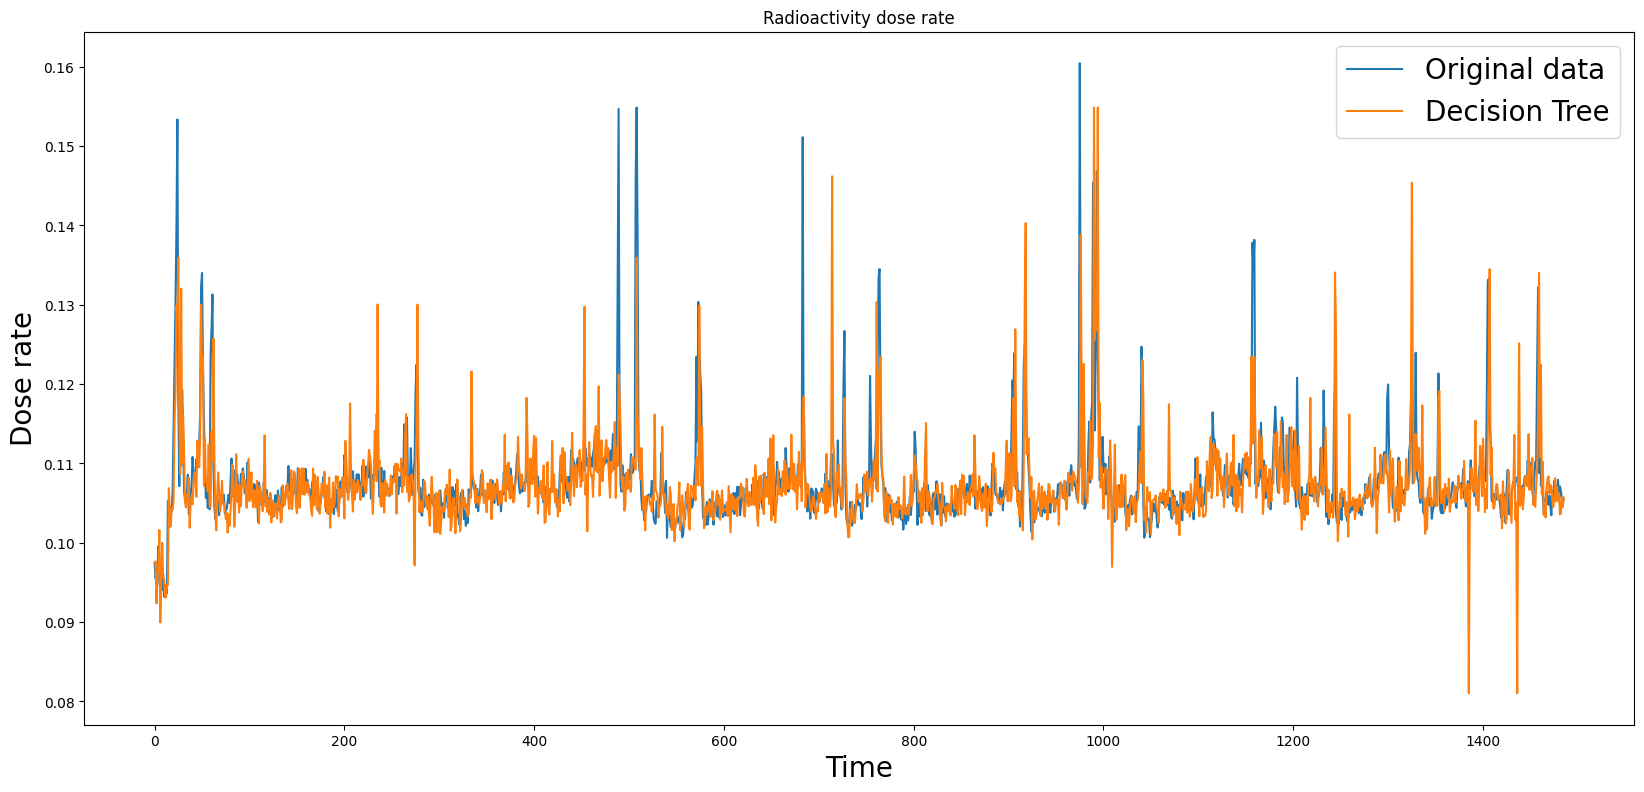

In [25]:
fig = plt.figure(figsize=(20, 9))

plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Decision Tree')

plt.legend(fontsize="20")
plt.title('Radioactivity dose rate')
plt.ylabel('Dose rate', fontsize="20")
plt.xlabel('Time', fontsize="20")
plt.show()

In [26]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.004)
model.fit(data[['dose_rate']])

IsolationForest(contamination=0.004)

In [27]:
data['outliers'] = pd.Series(model.predict(data[['dose_rate']])).apply(lambda x: 'yes' if (x == -1) else 'no' )
data.query('outliers=="yes"')

,dose_rate,outliers
Time,,
450,0.105795,yes
451,0.137388,yes
452,0.143208,yes
563,0.125147,yes
2724,0.129753,yes
2907,0.130030,yes
2908,0.139555,yes
3373,0.132059,yes
3391,0.111196,yes


In [28]:
fig = px.scatter(data.reset_index(), x='Time', y='dose_rate', color='outliers')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()